In [1]:
import numpy as np
import skimage.io as io
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage import img_as_ubyte
from skimage.draw import polygon2mask
from scipy.ndimage import binary_fill_holes
from skimage.transform import resize

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,  Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow import keras

2023-03-01 07:11:43.448852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 07:11:43.547842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 07:11:43.547857: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 07:11:44.043325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
def loading_dataset_images(paths, 
                           x_size=224,
                           y_size=224):
    
    unlabeled_data = io.imread_collection("Dia 26-11-2022/*")
    
    images = []
    
    for img in tqdm(unlabeled_data):
        images.append(resize(img, (x_size, y_size), anti_aliasing=True))
    
    return np.array(images)  

In [3]:
images = loading_dataset_images("Dia 26-11-2022/*")

100%|███████████████████████████████████████████| 66/66 [02:18<00:00,  2.10s/it]


In [9]:
height, width, z = images[0].shape

In [53]:
# Encoder part of the U-Net architecture
inputs = Input(shape=(height, width, z))

conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Decoder part of the U-Net architecture
up4 = UpSampling2D(size=(2, 2))(pool3)
conv4 = Conv2D(256, 3, activation='relu', padding='same')(up4)
up5 = UpSampling2D(size=(2, 2))(conv4)
conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
up6 = UpSampling2D(size=(2, 2))(conv5)
conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
outputs = Conv2D(1, 3, activation='sigmoid', padding='same')(conv6)

In [120]:
def unet(inputs, num_classes):

    # Downsample path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Upsample path
    up5 = UpSampling2D(size=(2, 2))(pool4)
    up5 = concatenate([up5, drop4], axis=3)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv3], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv2], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv1], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    
    outputs = Conv2D(num_classes, 3, activation='sigmoid', padding='same')(conv8)
    return outputs

In [121]:
outputs = unet(inputs, 1)

autoencoder = Model(inputs, outputs)

autoencoder.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001), metrics=["mae"])

In [122]:
history = autoencoder.fit(images,
                          images,
                          shuffle=True,
                          epochs=3,
                          batch_size=8)

Epoch 1/3
9/9 [==============================] - 49s 5s/step - loss: 0.1532 - mae: 0.3435
Epoch 2/3
9/9 [==============================] - 51s 6s/step - loss: 0.1662 - mae: 0.3580
Epoch 3/3
9/9 [==============================] - 45s 5s/step - loss: 0.1662 - mae: 0.3580


In [125]:
images.shape

(66, 224, 224, 3)

In [ ]:
preds = autoencoder.predict_generator(images)

In [ ]:
mask_pred

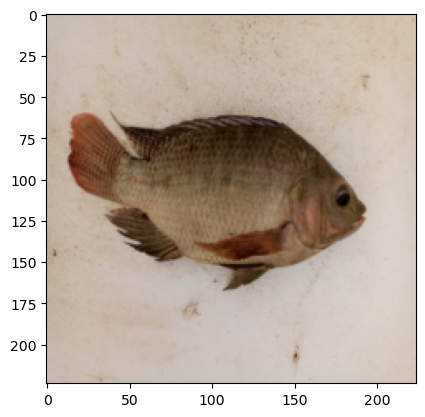

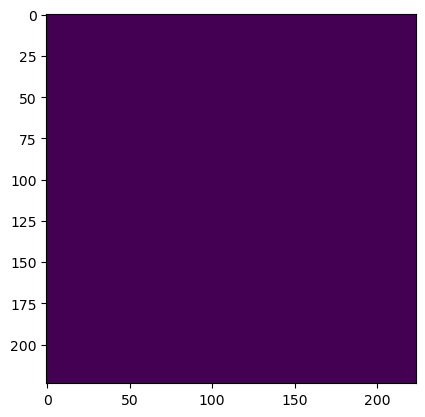

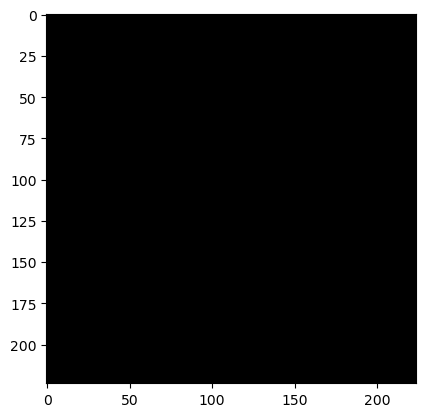

In [127]:
index = 0

mask_pred = preds[index].reshape((height, width))
mask = (mask_pred > mask_pred.mean())

plt.imshow(images[index])
plt.show()
plt.imshow(mask)
plt.show()

merged = images[index].copy()

merged[:,:,0] *= mask
merged[:,:,1] *= mask
merged[:,:,2] *= mask

plt.imshow(merged)

In [117]:
merged = io.imread_collection("Dia 26-11-2022/*")[index][:,:,:3]
x, y, z = merged.shape

In [118]:
result = resize(mask, (x, y), anti_aliasing=False)

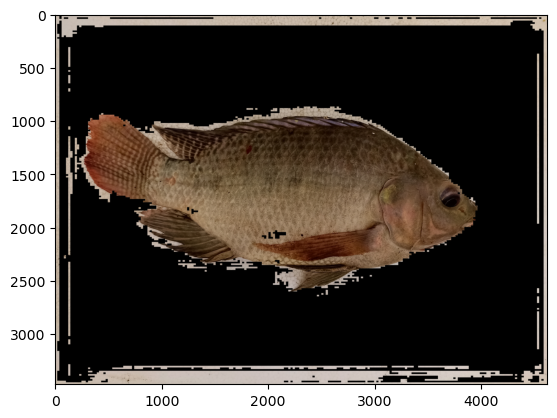

In [119]:
merged[:,:, 0] *= result
merged[:,:, 1] *= result
merged[:,:, 2] *= result

plt.imshow(merged)